# Lesson 16: Decision Tree

## **Project: Cell body segmentation prediction using machine learning**
- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340
- **Date**: 02/10/25
- **Goal**: Create a basic prediction model and a feature explainer

In [2]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
        train_test_split,
        cross_validate,
        cross_val_predict,
        GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [3]:
X, y = load_iris(return_X_y=True, as_frame=True)
df_raw = X
df_raw['species'] = y
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [4]:
df_raw.sample(10, random_state= 2025)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
2,4.7,3.2,1.3,0.2,0
148,6.2,3.4,5.4,2.3,2
112,6.8,3.0,5.5,2.1,2
132,6.4,2.8,5.6,2.2,2
0,5.1,3.5,1.4,0.2,0
113,5.7,2.5,5.0,2.0,2
34,4.9,3.1,1.5,0.2,0
51,6.4,3.2,4.5,1.5,1
135,7.7,3.0,6.1,2.3,2
5,5.4,3.9,1.7,0.4,0


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [5]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()
#df_baking['species'] = df_baking['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
#df_baking['species'] = df_baking['species'].astype("category")
df = df_baking.copy()
df

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
 4   species          150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [7]:
df.sample(10, random_state=2025)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,species
2,4.7,3.2,1.3,0.2,0
148,6.2,3.4,5.4,2.3,2
112,6.8,3.0,5.5,2.1,2
132,6.4,2.8,5.6,2.2,2
0,5.1,3.5,1.4,0.2,0
113,5.7,2.5,5.0,2.0,2
34,4.9,3.1,1.5,0.2,0
51,6.4,3.2,4.5,1.5,1
135,7.7,3.0,6.1,2.3,2
5,5.4,3.9,1.7,0.4,0


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [8]:
df_train, df_test=  train_test_split(df, test_size=0.2, stratify=df['species'], random_state=2025)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 100 to 110
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  120 non-null    float64
 1   sepal_width_cm   120 non-null    float64
 2   petal_length_cm  120 non-null    float64
 3   petal_width_cm   120 non-null    float64
 4   species          120 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.6 KB


In [9]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
sepal_length_cm,120.0,5.830000,0.814119,4.3,5.100,5.8,6.4,7.9
sepal_width_cm,120.0,3.054167,0.436159,2.0,2.800,3.0,3.4,4.4
petal_length_cm,120.0,3.753333,1.766016,1.1,1.575,4.4,5.1,6.9
petal_width_cm,120.0,1.203333,0.760355,0.1,0.300,1.3,1.8,2.5
species,120.0,1.000000,0.819920,0.0,0.000,1.0,2.0,2.0


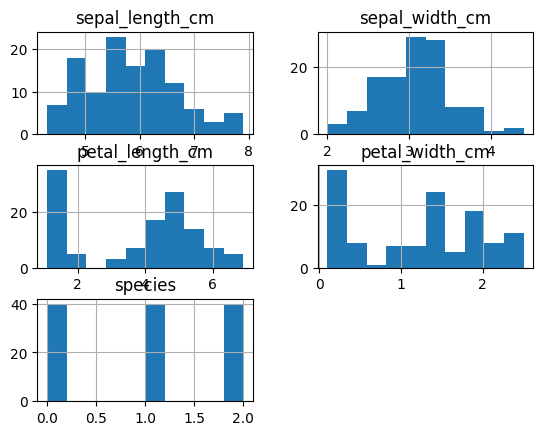

In [10]:
# Analisis univariado
df_train.hist()
plt.show()

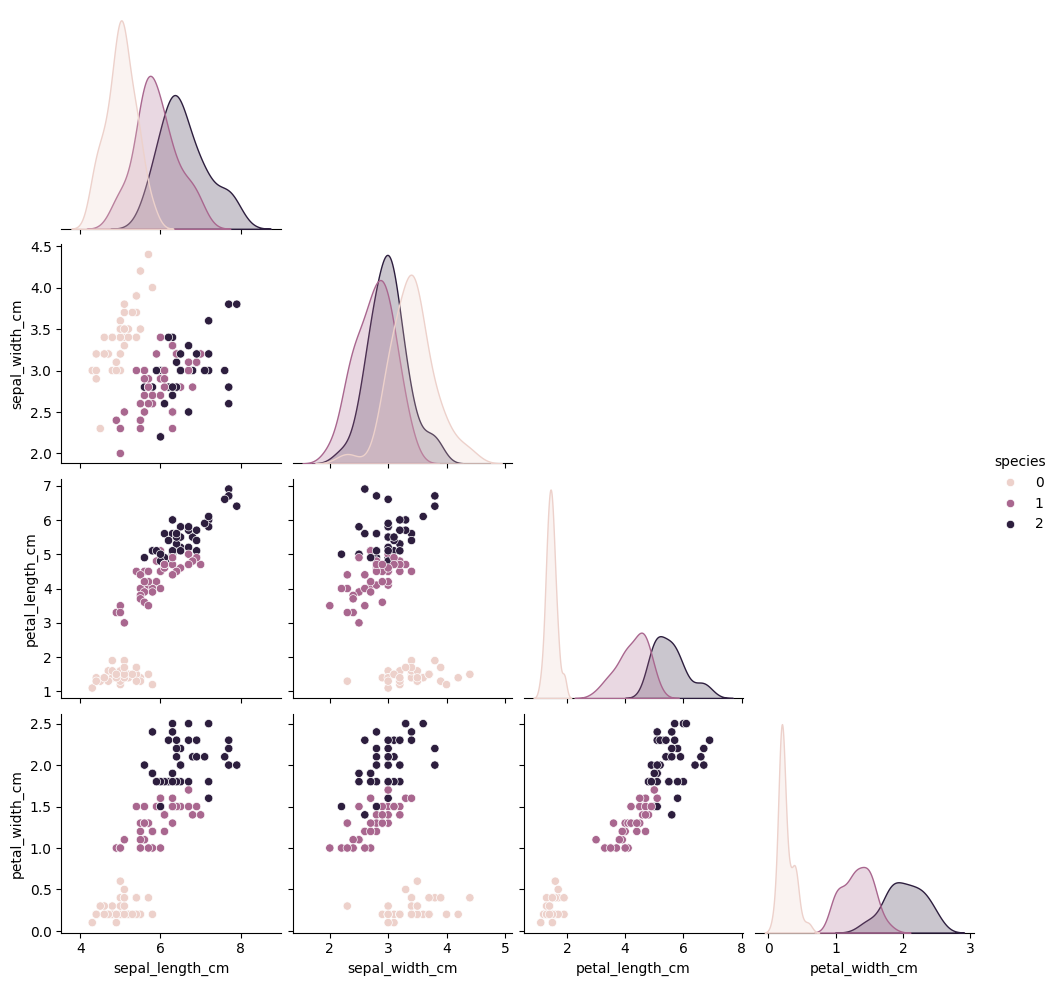

In [11]:
sns.pairplot(data=df_train, hue='species', corner=True)
plt.show()

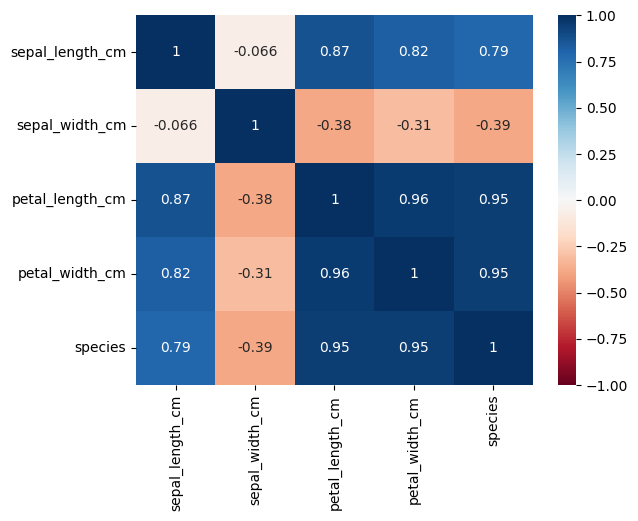

In [12]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [13]:
X_train = df_train.drop(columns=['species']).reset_index(drop=True)
y_train = df_train['species'].reset_index(drop=True)
X_test = df_test.drop(columns=['species']).reset_index(drop=True)
y_test = df_test['species'].reset_index(drop=True)
X_train

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,6.3,3.3,6.0,2.5
1,5.4,3.9,1.7,0.4
2,5.6,2.8,4.9,2.0
3,6.3,3.4,5.6,2.4
4,6.2,2.8,4.8,1.8
...,...,...,...,...
115,6.3,2.5,4.9,1.5
116,7.6,3.0,6.6,2.1
117,6.3,2.3,4.4,1.3
118,4.6,3.2,1.4,0.2


In [14]:
clf_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=3) # balancea de una manera ponderada
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

In [15]:
y_hat =  clf_tree.predict(X_test)
print(f'accuracy: {accuracy_score(y_test,y_hat)*100:.1f}')
# print(f'f1 score: {f1_score(y_test_enc,y_hat)*100:.1f}')

accuracy: 96.7


accuracy: 96.67
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



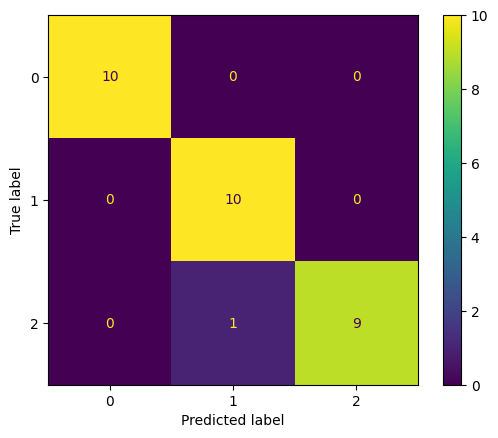

In [16]:
y_hat_val = clf_tree.predict(X_test)
print(f'accuracy: {accuracy_score(y_test,y_hat)*100:.2f}')
#print(f'f1 score: {f1_score(y_val_enc,y_hat_val)*100:.2f}')
print(classification_report(y_test,y_hat))
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
plt.show()

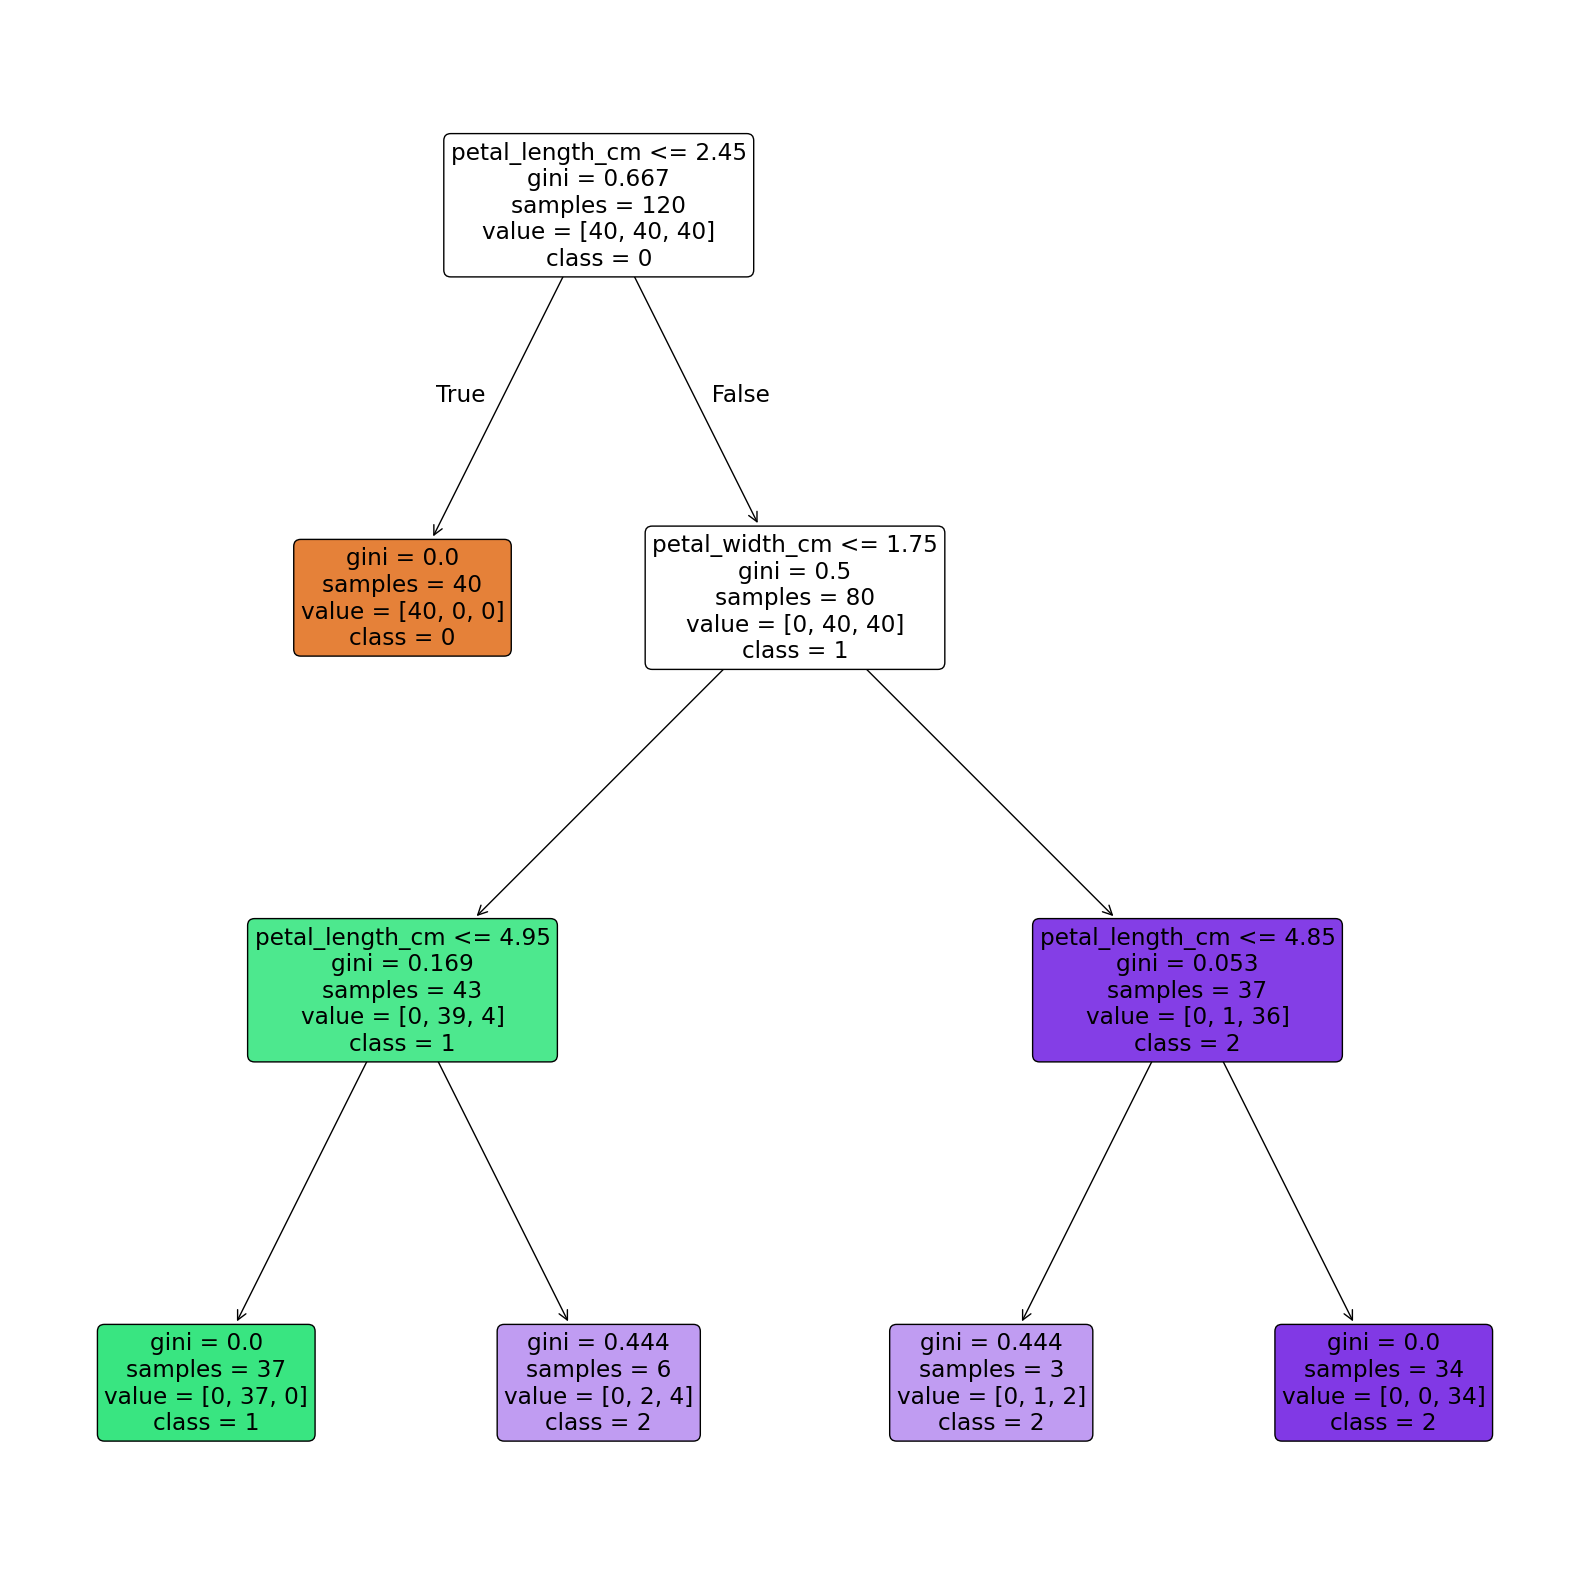

In [17]:
plt.figure(figsize=(16,16))
plot_tree(clf_tree, feature_names=X_train.columns, rounded= True,class_names=['0','1','2'], filled=True)
plt.tight_layout()
plt.show()

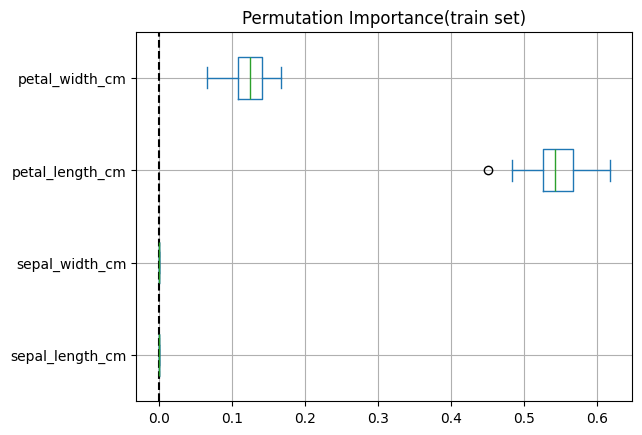

In [18]:
importance = permutation_importance(clf_tree,X_train,y_train,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()


In [21]:
with open("../models/clf_tree_model.pkl", "wb") as iris_tree:
    pickle.dump(clf_tree, iris_tree)

In [22]:
with open("../models/clf_tree_model.pkl", "rb") as file:
    modelx = pickle.load(file)

In [26]:
predict_df = pd.DataFrame({'sepal_length_cm':[4.7], 'sepal_width_cm':[3.2], 'petal_length_cm':[1.3], 'petal_width_cm':[0.2]})

In [27]:
#modelx.predict([[4.7,3.2,1.3,0.2]])
modelx.predict(predict_df)

array([0])